In [1]:
import pandas as pd
import numpy as np
import model as deep
import experiment as exp
import myutil as util
from itertools import product

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'c:\\Users\\kyeongtaek\\generative_model\\foresttype\\experiment.py'>

In [2]:
#파일 읽기
filepath_german_csv = 'covtype.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]-1

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

In [4]:
d_german_np.shape

(581011, 55)

In [3]:
print(d_german_np[:, n_features])
print(y)

[5 2 2 ... 3 3 3]
[4 1 1 ... 2 2 2]


In [61]:
x_norm

array([[0.36568284, 0.15555556, 0.03030303, ..., 0.        , 0.        ,
        0.        ],
       [0.47273637, 0.38611111, 0.13636364, ..., 0.        , 0.        ,
        0.        ],
       [0.46323162, 0.43055556, 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.26363182, 0.44166667, 0.25757576, ..., 0.        , 0.        ,
        0.        ],
       [0.26263132, 0.47222222, 0.22727273, ..., 0.        , 0.        ,
        0.        ],
       [0.26213107, 0.45833333, 0.1969697 , ..., 0.        , 0.        ,
        0.        ]])

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14143551849611006996
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22219821016
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10781229131358393350
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

1816/1816 [==============================] - 5s 2ms/step
0/10	 test_acc:0.9341491540593105


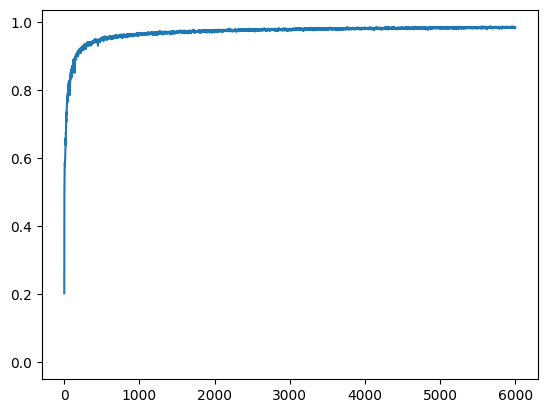

1816/1816 [==============================] - 3s 2ms/step
1/10	 test_acc:0.9391576737061325


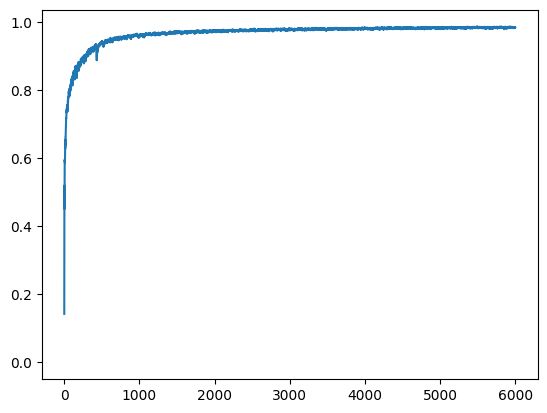

1816/1816 [==============================] - 3s 2ms/step
2/10	 test_acc:0.9284521781036471


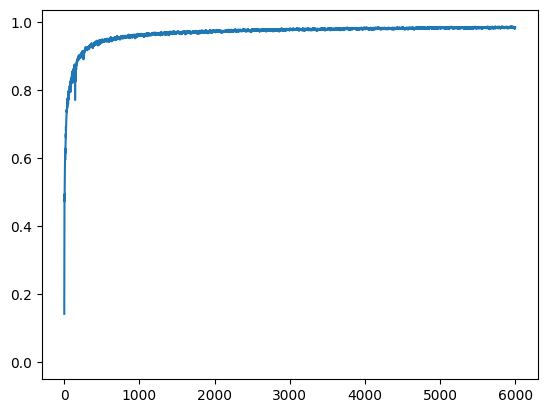

1816/1816 [==============================] - 3s 2ms/step
3/10	 test_acc:0.939880552830416


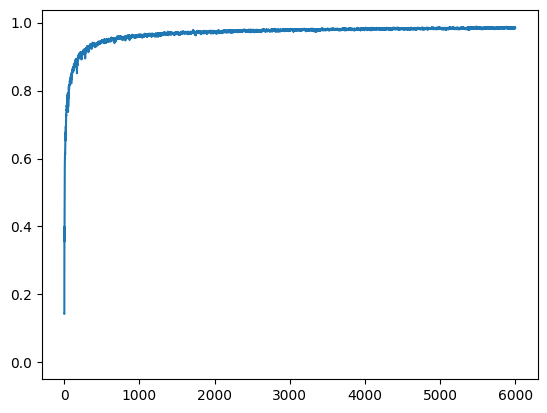

1816/1816 [==============================] - 3s 2ms/step
4/10	 test_acc:0.9388306569594327


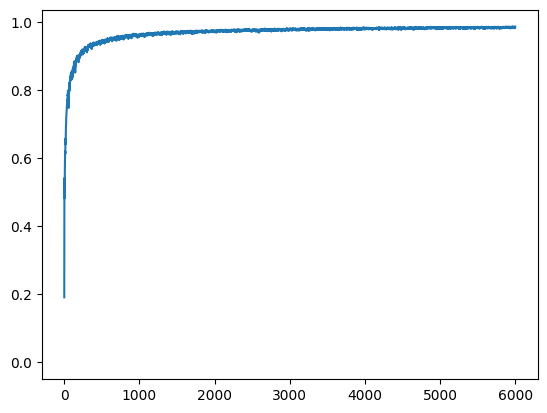

1816/1816 [==============================] - 3s 2ms/step
5/10	 test_acc:0.9330648353728851


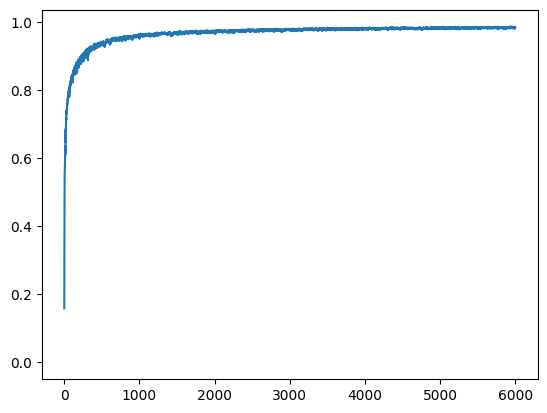

1816/1816 [==============================] - 3s 2ms/step
6/10	 test_acc:0.9391748851138535


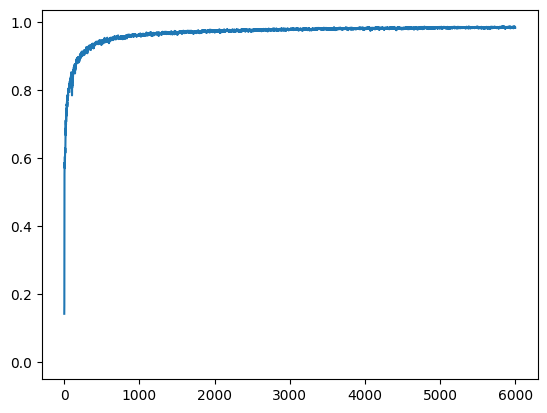

1816/1816 [==============================] - 3s 2ms/step
7/10	 test_acc:0.9318256140169704


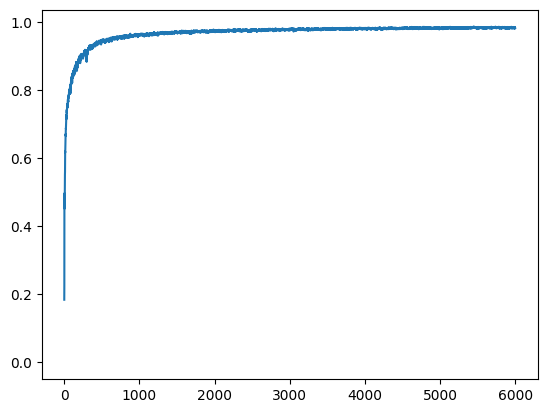

1816/1816 [==============================] - 3s 2ms/step
8/10	 test_acc:0.9355260666769936


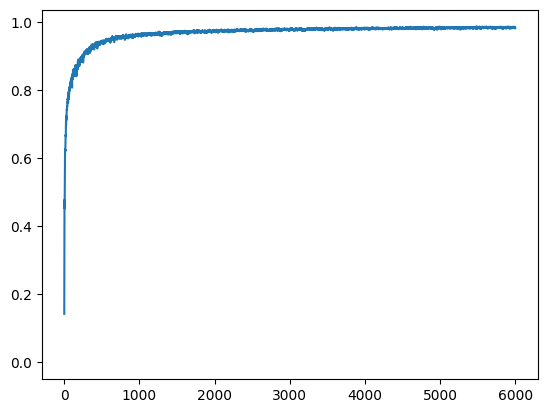

1816/1816 [==============================] - 4s 2ms/step
9/10	 test_acc:0.9353367411920621


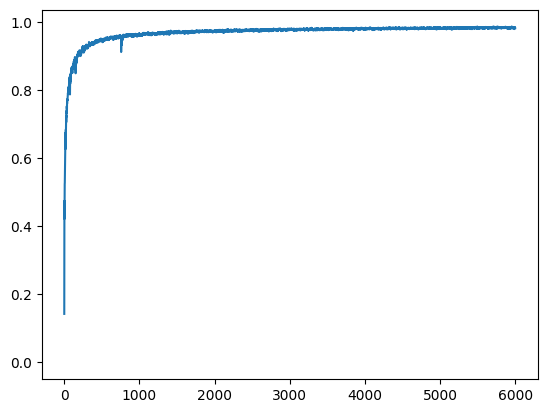

average accuracy : 0.9355398358031705


In [5]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.1, val_ratio=0.1)

    # 모델 불러오기 & 컴파일
    m = deep.get_model_gen(x.shape[1:])
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=1000, batch_size_per_class=64)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_test)), -1) == y_test) / y_test.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기
    
    # hyperparameters
    
    nbatch_size = [2048]
    nlearning_rate = [0.001]
    nepochs  = [6000]
    
    cols = ['batch_size', 'learning_rate', 'epochs', 'test acc', 'loss']
    perform_df = pd.DataFrame(columns = cols)
    
    #grid search
    g_i = 0

    N = 10
    nClass = 7
    cm_sum = np.zeros([nClass, nClass])
    
    for bs, lr, e in product(nbatch_size, nlearning_rate, nepochs):
        g_i += 1
        total = 0
        total_std = 0
        for i in range(N):
            # Train/Test 데이터 분할
            [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x_norm, y, test_ratio=0.1, val_ratio=0)

            # 모델 불러오기 & 컴파일
            m = deep.get_model_gen(x.shape[1:])
            #m = deep.get_model(x.shape[1:])

            # m = deep.get_model(x.shape[1:])
            m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # 학습시 사용하는 옵션
            train_options = exp.TrainParams(m, epochs=e, batch_size_per_class=bs)

            # 학습
            result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)

            # 테스트
            o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
            test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
            train_loss_tmp = result.train_loss[-1]
            cm = np.zeros([nClass, nClass])
            for j in range(y_test.shape[0]):
                cm[int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산
            cm_sum += cm

            # 결과 출력
            print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
            plt.plot(result.train_acc)
            plt.plot(result.val_acc)
            plt.show()
            total = total + test_acc_tmp
            total_std = total_std + train_loss_tmp
        ave = total/10
        avl = total_std/10
        perform_df.loc[g_i] = [bs, lr, e, ave, avl]
        print(f'average accuracy : {ave}')

In [11]:
np.set_printoptions(precision=6, suppress=True)
print(cm_sum)
print(cm)

[[197923.  11243.     15.      0.    305.     47.   2005.]
 [ 15270. 263653.   1245.      2.   2485.    905.    373.]
 [     7.    254.  34343.    241.     68.    868.      0.]
 [     0.      0.    180.   2436.      0.     79.      0.]
 [    55.    399.     76.      0.   8830.     36.      1.]
 [    10.    164.    702.     85.     28.  16309.      0.]
 [   267.     34.      0.      0.      3.      0.  20064.]]
[[20226.   956.     1.     0.    18.     4.   197.]
 [ 1667. 25987.   126.     0.   268.   101.    38.]
 [    3.    37.  3389.    24.     8.    82.     0.]
 [    0.     0.    14.   229.     0.    13.     0.]
 [   12.    39.    12.     0.   908.     2.     0.]
 [    1.    16.    74.     7.     2.  1596.     0.]
 [   32.     3.     0.     0.     0.     0.  2009.]]


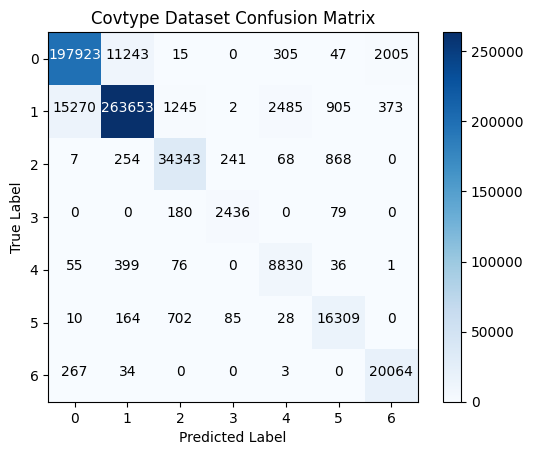

In [7]:
conf_matrix = cm_sum
# 시각화
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Covtype Dataset Confusion Matrix')
plt.colorbar()

classes = [0, 1, 2, 3, 4, 5, 6]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 각 셀에 숫자 표시
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(int(conf_matrix[i, j])),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

In [18]:
perform_df = perform_df.sort_values(by='test acc')
perform_df

,batch_size,learning_rate,epochs,test acc,loss
2,256.0,0.0001,6000.0,0.880715,0.145901
4,512.0,0.0001,6000.0,0.896597,0.122357
1,256.0,0.0010,6000.0,0.899611,0.105166
6,1024.0,0.0001,6000.0,0.904444,0.103100
8,2048.0,0.0001,6000.0,0.913029,0.091206
3,512.0,0.0010,6000.0,0.916695,0.076327
5,1024.0,0.0010,6000.0,0.926206,0.059520
7,2048.0,0.0010,6000.0,0.935881,0.043202


In [34]:
#MLP
perform_df = perform_df.sort_values(by='test acc')
perform_df

,batch_size,learning_rate,epochs,test acc,loss
2,512.0,0.0001,10000.0,0.700215,0.462245
4,1024.0,0.0001,10000.0,0.709556,0.437300
6,2048.0,0.0001,10000.0,0.722187,0.411559
8,4096.0,0.0001,10000.0,0.734172,0.408002
1,512.0,0.0010,10000.0,0.797809,0.270521
3,1024.0,0.0010,10000.0,0.811492,0.251940
5,2048.0,0.0010,10000.0,0.822043,0.236058
7,4096.0,0.0010,10000.0,0.832698,0.231155
